# Wearables Lab 3 - Hedman, Koivisto & Wahlin

In [1029]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
import scipy.linalg
import seaborn as sns
sns.set_theme(style='darkgrid')

from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from scipy.signal import filtfilt
from scipy.signal import butter
from mne.viz import plot_topomap
from mne.decoding import CSP

## Helper Funcitons

In [1030]:
# CSP
def CSP_weights(X, y, n_components=8):
    # X dimensions: (epochs, channels, samples)
    n_channels = X.shape[1]
    
    # Calculate cov matrix for each class
    covs = []
    for c in np.unique(y):
        # Extract the data for the current class
        X_class = X[y == c] 
        
        # Calculate the cov matrix for each epoch
        cov_class = np.zeros((n_channels, n_channels))
        for epoch in X_class:
            cov_class += np.cov(epoch)
        
        # Average of cov matrices
        cov_class /= len(X_class)
        
        covs.append(cov_class)
        
    S1 = covs[0]  # Covariance matrix for class 0
    S2 = covs[1]  # Covariance matrix for class 1

    E, U = scipy.linalg.eigh(S1, S2)

    # Sort eigenvalues and eigenvectors
    idx = np.argsort(E)[::-1]  # Sort eigenvalues in descending order
    E = E[idx]
    U = U[:, idx]
    
    # Select the first n_components eigenvectors
    W_csp = U[:, :n_components]

    return W_csp

# LDA
def LDA_weights(X, y, n_components=1):
    n_features = X.shape[1]
    class_labels = np.unique(y)

    mean_overall = np.mean(X, axis=0)
    SW = np.zeros((n_features, n_features))
    SB = np.zeros((n_features, n_features))

    for c in class_labels:
        X_c = X[y == c]
        mean_c = np.mean(X_c, axis=0)
        
        # Within-class scatter matrix
        SW += (X_c - mean_c).T.dot((X_c - mean_c))
        
        # Between-class scatter matrix
        n_c = X_c.shape[0]
        mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
        SB += n_c * mean_diff.dot(mean_diff.T)

    # Compute the LDA projection matrix
    A = np.linalg.inv(SW).dot(SB)

    # Eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eig(A)

    # Sort the eigenvectors based on the eigenvalues
    idxs = np.argsort(abs(eigvals))[::-1]
    eigvals = eigvals[idxs]
    eigvecs = eigvecs[:, idxs]

    # Return the first n eigenvectors
    return eigvecs[:, :n_components]

## Load the Data

In [1031]:
# Load the data
acc_data1 = loadmat('Data/EEG_IMU/Accelerometer_data_trial1.mat')
acc_data2 = loadmat('Data/EEG_IMU/Accelerometer_data_trial2.mat')
eeg_data1 = loadmat('Data/EEG_IMU/EEG_data_trial1.mat')
eeg_data2 = loadmat('Data/EEG_IMU/EEG_data_trial2.mat')

# Display the keys of the loaded data
print("Keys of acc_data1:", acc_data1.keys())
print("Keys of acc_data2:", acc_data2.keys())
print("Keys of eeg_data1:", eeg_data1.keys())
print("Keys of eeg_data2:", eeg_data2.keys())
print(eeg_data1['BioRadioData'].shape)
print(eeg_data1['eegtimestamp'].shape)

Keys of acc_data1: dict_keys(['__header__', '__version__', '__globals__', 'Accelerometer', 'time'])
Keys of acc_data2: dict_keys(['__header__', '__version__', '__globals__', 'Accelerometer', 'time'])
Keys of eeg_data1: dict_keys(['__header__', '__version__', '__globals__', 'BioRadioData', 'eegtimestamp'])
Keys of eeg_data2: dict_keys(['__header__', '__version__', '__globals__', 'BioRadioData', 'eegtimestamp'])
(1, 8)
(74963, 1)


## Data Processing

### Accelerometer

In [1032]:
# Extract accelerometer data
acc_data1_df = pd.DataFrame(acc_data1['Accelerometer'], columns=['X', 'Y', 'Z'])
acc_data1_df['Time'] = acc_data1['time']

acc_data2_df = pd.DataFrame(acc_data2['Accelerometer'], columns=['X', 'Y', 'Z'])
acc_data2_df['Time'] = acc_data2['time']

# Display the first few rows of the dataframes
acc_data2_df.head()

,X,Y,Z,Time
0,-0.989017,0.191124,-0.131862,0.101
1,-0.989017,0.178702,-0.131862,0.101
2,-1.001440,0.166279,-0.131862,0.121
3,-1.001440,0.166279,-0.131862,0.129
4,-1.001440,0.178702,-0.131862,0.140


In [1033]:
# Create traces for each axis
trace_x = go.Scatter(x=acc_data2_df['Time'], y=acc_data2_df['X'],
mode='lines', name='x')
trace_y = go.Scatter(x=acc_data2_df['Time'], y=acc_data2_df['Y'],
mode='lines', name='y')
trace_z = go.Scatter(x=acc_data2_df['Time'], y=acc_data2_df['Z'],
mode='lines', name='z')

# Create the layout
layout = go.Layout(
title='IMU Signal',
xaxis=dict(title='Time (s)'),
yaxis=dict(title='Acceleration (m/s^2)'),)

# Create the figure
fig = go.Figure(data=[trace_x, trace_y, trace_z],
layout=layout)

# Display the figure
fig.show()

# EVENT MARKERS IN ACC DATA 1 = 32
# EVENTS IN ACC DATA 2 = 26

### EEG

In [1034]:
# Initialize the data frames for the EEG data
eeg_data1_df = pd.DataFrame(eeg_data1['eegtimestamp'], columns=['Timestamp'])
eeg_data2_df = pd.DataFrame(eeg_data2['eegtimestamp'], columns=['Timestamp'])

_, n_channels = eeg_data1['BioRadioData'].shape

for i in range(n_channels):
    temp_df = pd.DataFrame(eeg_data1['BioRadioData'][0][i], columns=['Channel ' + str(i + 1)]) 
    eeg_data1_df = pd.concat([eeg_data1_df, temp_df], axis=1)
    
    temp_df = pd.DataFrame(eeg_data2['BioRadioData'][0][i], columns=['Channel ' + str(i + 1)]) 
    eeg_data2_df = pd.concat([eeg_data2_df, temp_df], axis=1)

eeg_data1_df['Trial'] = 1
eeg_data2_df['Trial'] = 2   

eeg_data1_df.head()

,Timestamp,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Trial
0,0.000,-0.005771,0.015134,-0.002155,-0.014824,0.021869,0.003758,-0.057939,-0.004788,1
1,0.002,-0.005774,0.015133,-0.002154,-0.014827,0.021863,0.003757,-0.057937,-0.004796,1
2,0.004,-0.005775,0.015133,-0.002155,-0.014828,0.021862,0.003756,-0.057938,-0.004794,1
3,0.006,-0.005776,0.015133,-0.002153,-0.014827,0.021863,0.003758,-0.057938,-0.004781,1
4,0.008,-0.005776,0.015133,-0.002152,-0.014827,0.021867,0.003759,-0.057937,-0.004775,1


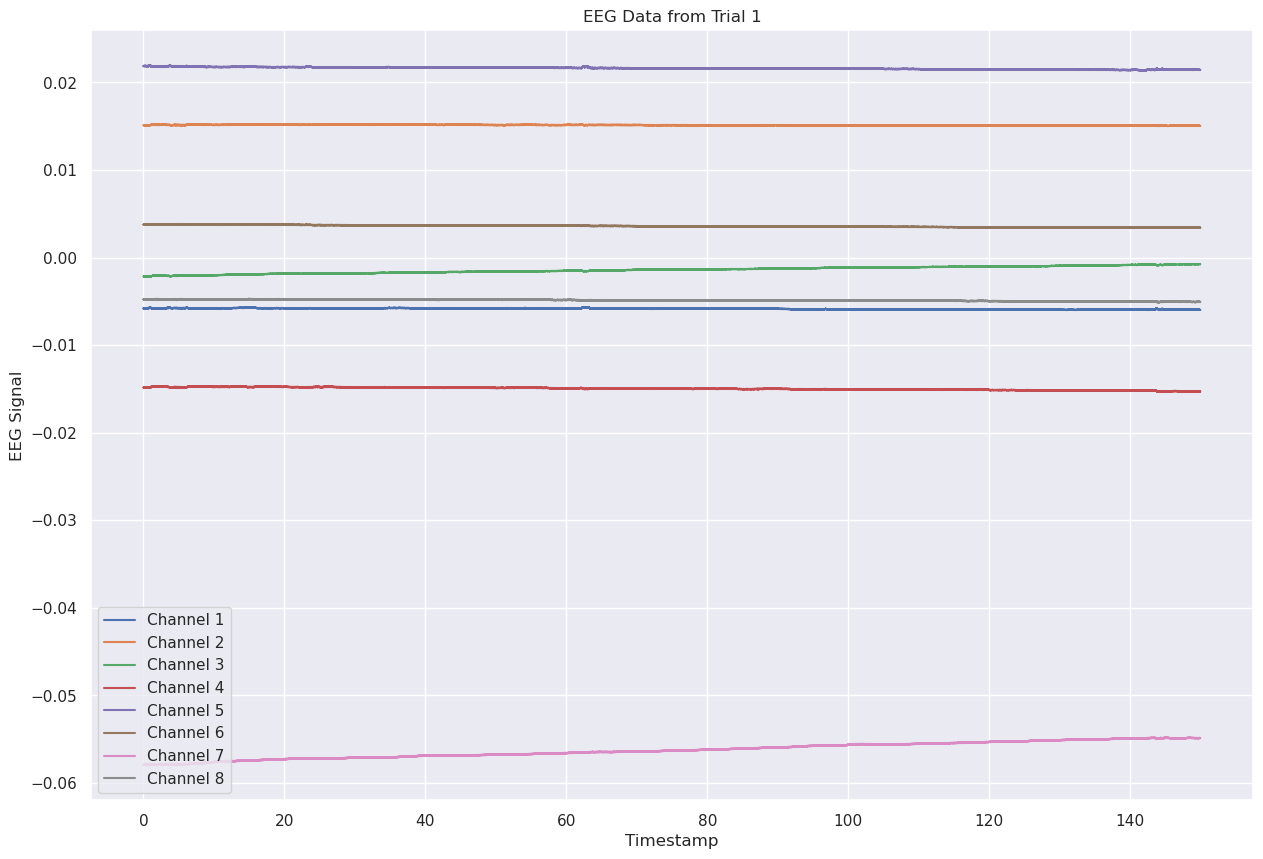

In [1035]:
# Plot unfiltered EEG data
eeg_data1_df.plot(x='Timestamp', y=['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8'], figsize=(15, 10), title='EEG Data from Trial 1')
plt.xlabel('Timestamp')
plt.ylabel('EEG Signal')
plt.show()

In [1036]:
eeg_data1_filtered_df = eeg_data1_df.copy()
eeg_data2_filtered_df = eeg_data2_df.copy()

# Butterworth filter parameters
sampling_rate = 500
nyquist = 0.5 * sampling_rate
cutoff_low = 1/nyquist
cutoff_high = 30/nyquist
b, a = butter(4, [cutoff_low, cutoff_high], btype='band', analog=False)

# Loop through the channels
for i in range(n_channels):
    # Apply the bandpass filter to the EEG data
    eeg_data1_filtered_df['Channel ' + str(i + 1)] = filtfilt(b, a, eeg_data1_filtered_df['Channel ' + str(i + 1)])
    eeg_data2_filtered_df['Channel ' + str(i + 1)] = filtfilt(b, a, eeg_data2_filtered_df['Channel ' + str(i + 1)])

eeg_data1_filtered_df.head()

,Timestamp,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Trial
0,0.000,0.000009,0.000005,9.173503e-08,3.576102e-06,0.000013,0.000005,0.000002,0.000004,1
1,0.002,0.000008,0.000004,-9.183335e-08,2.639988e-06,0.000012,0.000005,0.000002,0.000006,1
2,0.004,0.000007,0.000004,-3.045908e-07,1.739397e-06,0.000012,0.000006,0.000003,0.000007,1
3,0.006,0.000006,0.000004,-5.683054e-07,9.100776e-07,0.000012,0.000006,0.000003,0.000009,1
4,0.008,0.000005,0.000003,-8.962604e-07,1.708630e-07,0.000012,0.000007,0.000003,0.000010,1


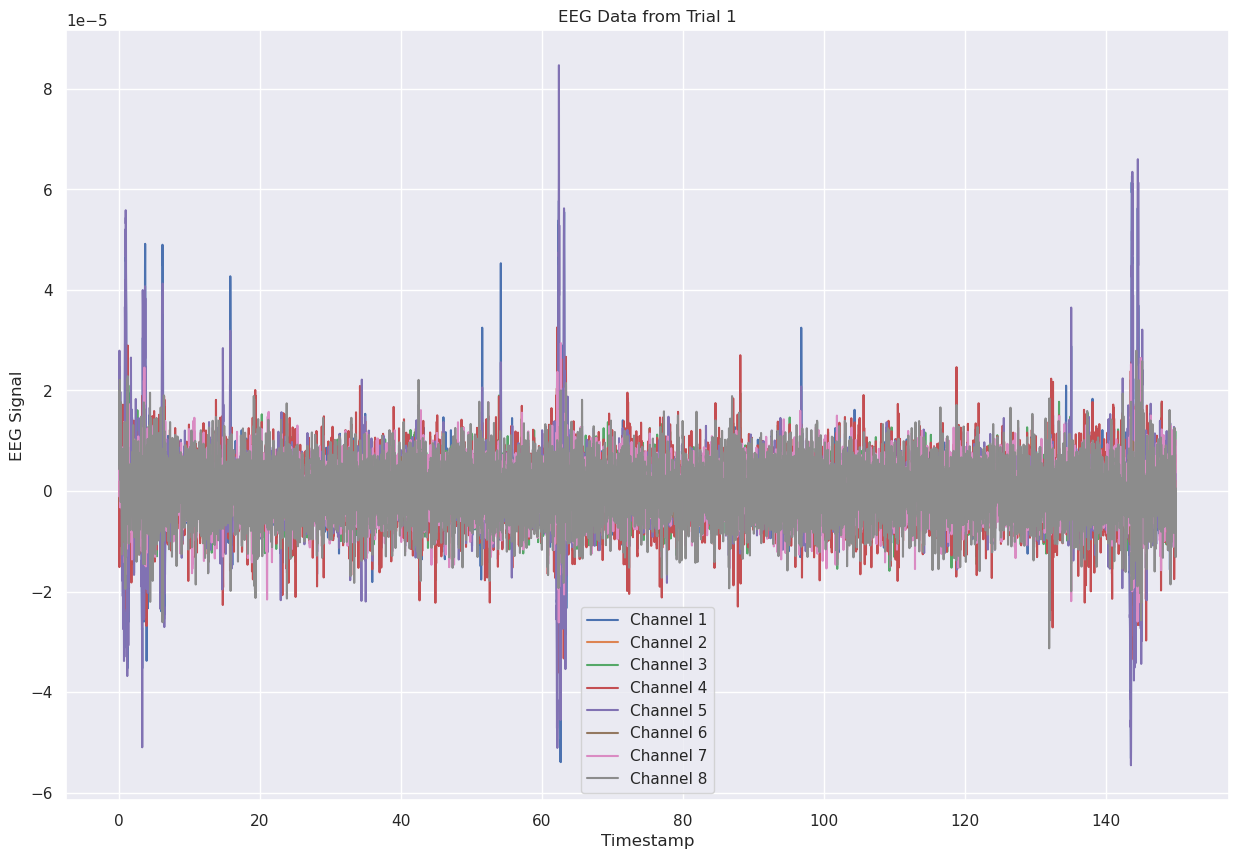

In [1037]:
# Plot filtered EEG data
eeg_data1_filtered_df.plot(x='Timestamp', y=['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8'], figsize=(15, 10), title='EEG Data from Trial 1')
plt.xlabel('Timestamp')
plt.ylabel('EEG Signal')
plt.show()

In [1038]:
# Timestamps obtained from visual inspection of the IMU data
time_points1=[5.7 ,8.4, 16.0, 18.1, 24.5, 26.9, 34.0, 37.0, 43.1, 46.3, 54.9, 56.9, 63.2, 65.3, 70.4, 73.2, 79.2, 82.3, 88.9, 91.0, 96.4, 99.2, 104.6, 107.8, 115.7, 117.8, 125.6, 127.9, 135.0, 137.1, 144.5, 146.6]
time_points2=[5.4 ,8.7, 18.7, 21.3, 28.8, 31.8, 40.2, 43.3, 50.9, 53.6, 61.3, 64.1, 71.4, 74.4, 81.4, 84.5, 91.1, 94.6, 104.7, 107.4, 115.4, 118.7, 126.8, 130.1, 138.1, 141.7]

epochs1_df = pd.DataFrame()
epochs2_df = pd.DataFrame()

# Extract the data points for each epoch
# EVENT MARKERS IN ACC DATA 1 = 32
# EVENTS IN ACC DATA 2 = 26
# Convert epochs_df to a numpy array
event = 0
epoch = 2

# Assign labels to the data points, 0 - hand to mouth, 1 - writing
label = 0

X = np.zeros((8, epoch*500, 58))
y = np.array([])

# exlude last time point


for t in time_points1:
    temp_df = eeg_data1_filtered_df[(eeg_data1_filtered_df['Timestamp'] >= t) & (eeg_data1_filtered_df['Timestamp'] <= t + epoch)]
    feature_array = temp_df.drop(['Timestamp', 'Trial'], axis=1).values    
    
    print(t)
    X[:, :, event] = feature_array.T
    y = np.append(y, label)
    
    if label == 0:
        label = 1
    else:
        label = 0
    
    event+=1
    
label = 0    

for t in time_points2:
    temp_df = eeg_data1_filtered_df[(eeg_data1_filtered_df['Timestamp'] >= t) & (eeg_data1_filtered_df['Timestamp'] <= t + epoch)]
    feature_array = temp_df.drop(['Timestamp', 'Trial'], axis=1).values
    X[:, :, event] = feature_array.T
    y = np.append(y, label)
    
    if label == 0:
        label = 1
    else:
        label = 0
    
    event+=1

X_transposed = np.transpose(X, [2, 0, 1])

X_train, X_test, y_train, y_test = train_test_split(X_transposed, y, test_size=0.25, random_state=0)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

5.7
8.4
16.0
18.1
24.5
26.9
34.0
37.0
43.1
46.3
54.9
56.9
63.2
65.3
70.4
73.2
79.2
82.3
88.9
91.0
96.4
99.2
104.6
107.8
115.7
117.8
125.6
127.9
135.0
137.1
144.5
146.6
(43, 8, 1000) (43,) (15, 8, 1000) (15,)


## Common Spatial Pattern

### Own Implementation

In [1039]:
# CSP weights
W = CSP_weights(X_train, y_train)
W.shape

(8, 8)

In [1040]:
# Normalize the CSP components
for i in range(W.shape[1]):
    W[:, i] /= np.linalg.norm(W[:, i])
    W[:, i] *= np.sign(W[0, i])

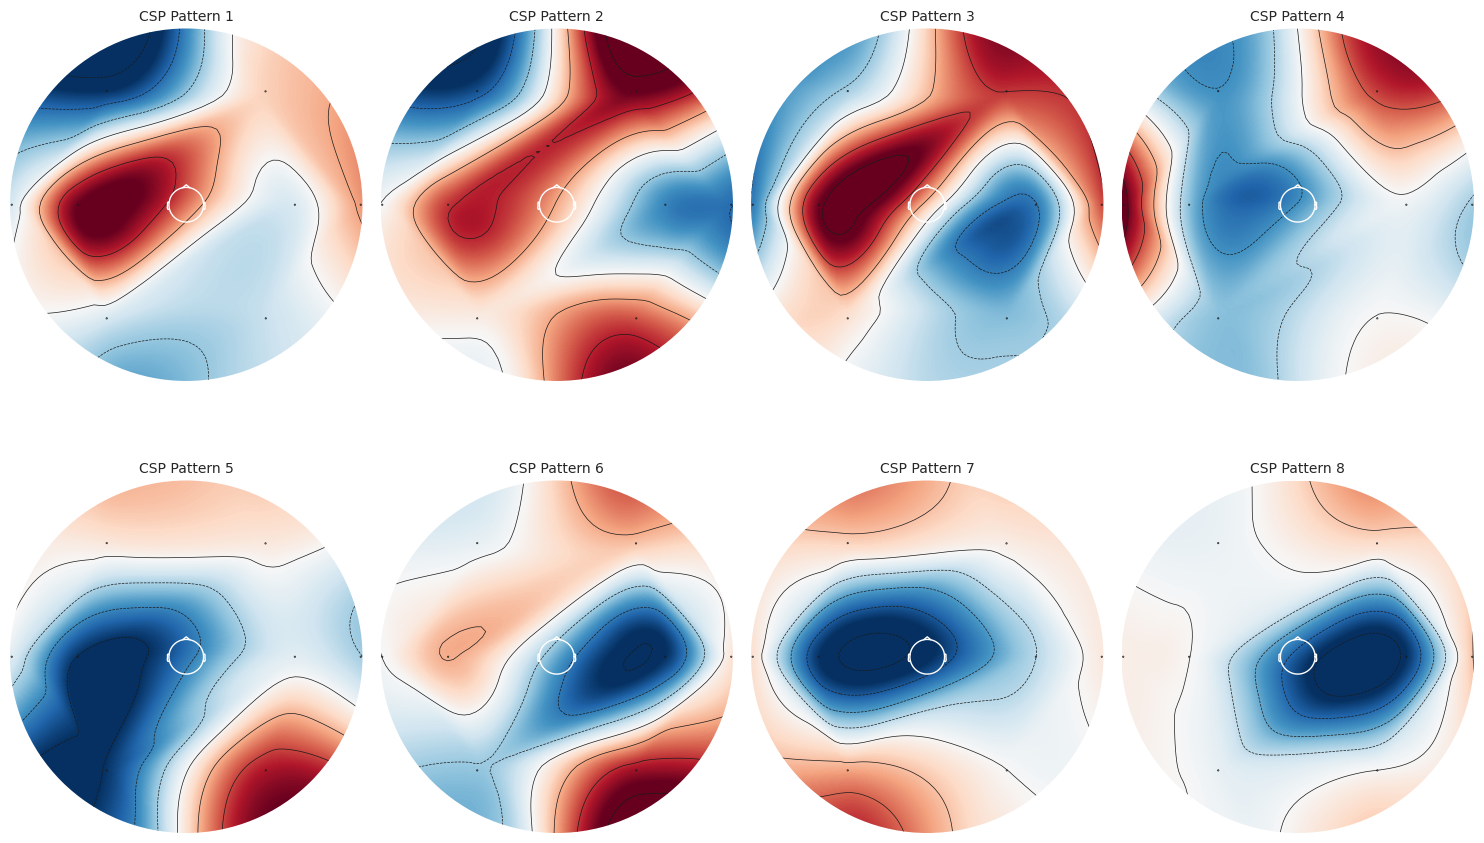

In [1041]:
# Plot the CSP components
chanlocs = loadmat('Data/chanloc.mat')['chanlocs']
chX=[]
chY=[]
for i in range(np.shape(chanlocs)[1]):
    chX.extend(chanlocs['X'][0][i][0])
    chY.extend(chanlocs['Y'][0][i][0])
chX=np.array(chX)
chY=np.array(chY)
#chX, chY=polar_to_cartesian(chX, chY)
chans=np.vstack([chY,chX]).T
# Plot topomap
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
for i in range(W.shape[1]):
    ax = axes[i // 4, i % 4]
    plot_topomap(W[:, i], chans, axes=ax, show=False)
    ax.set_title(f'CSP Pattern {i+1}', fontsize=10)
plt.tight_layout()
plt.show()

### MNE CSP

In [1042]:
csp = CSP(n_components=8, reg=None, log=None, norm_trace=True)
csp.fit(X_train, y_train)
csp_patterns = csp.patterns_

print(csp_patterns.shape)

Computing rank from data with rank=None
    Using tolerance 3.4e-06 (2.2e-16 eps * 8 dim * 1.9e+09  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0.0 covariance using EMPIRICAL
Done.
Estimating class=1.0 covariance using EMPIRICAL
Done.
(8, 8)


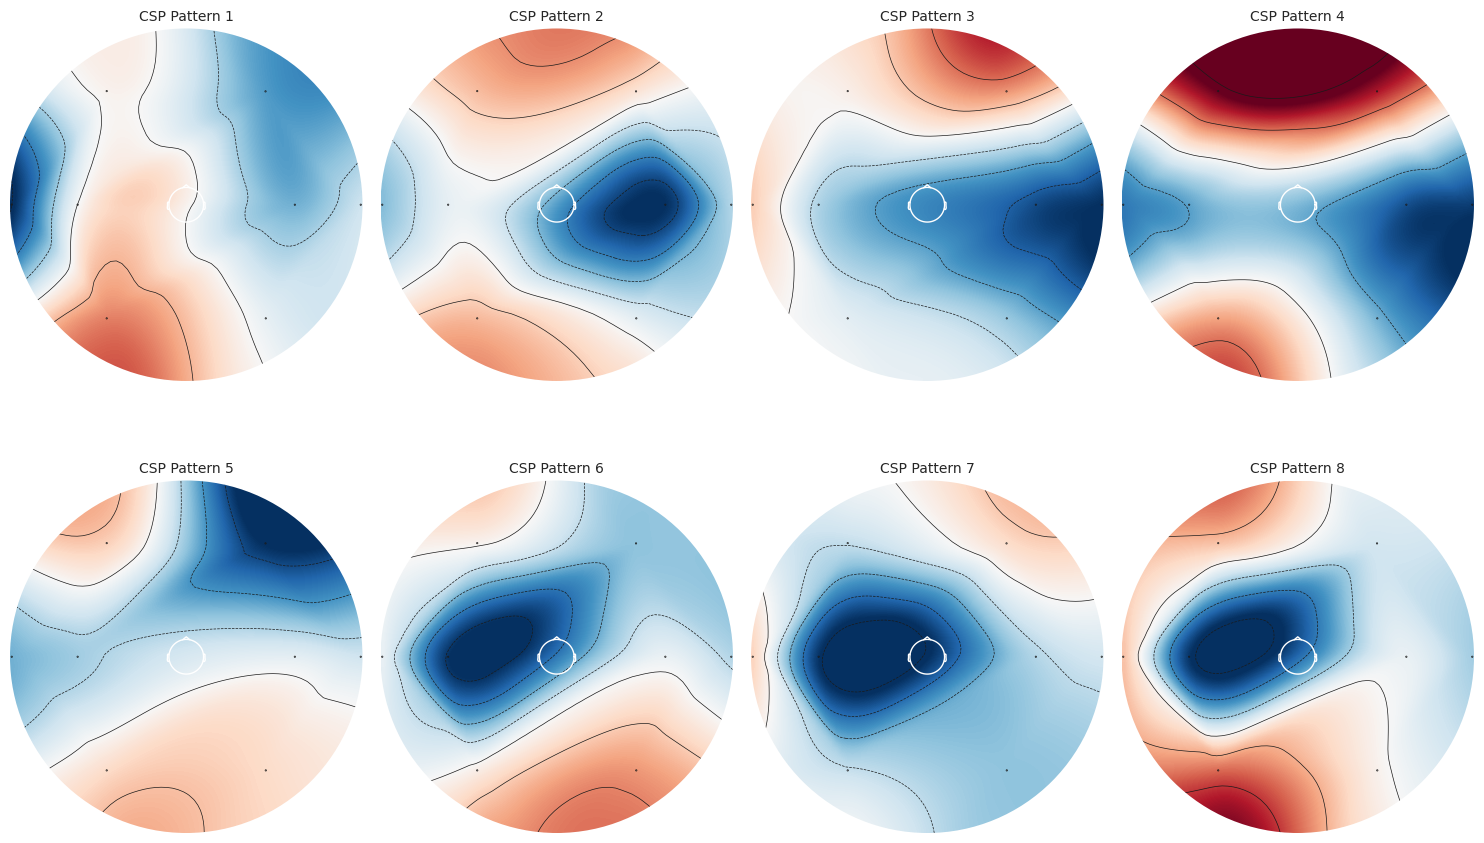

In [1043]:
# Plot the CSP components
chX=[]
chY=[]
for i in range(np.shape(chanlocs)[1]):
    chX.extend(chanlocs['X'][0][i][0])
    chY.extend(chanlocs['Y'][0][i][0])
chX=np.array(chX)
chY=np.array(chY)
chans=np.vstack([chY,chX]).T
# Plot topomap
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
for i in range(csp_patterns.shape[1]):
    ax = axes[i // 4, i % 4]
    plot_topomap(csp_patterns[:, i], chans, axes=ax, show=False)
    ax.set_title(f'CSP Pattern {i+1}', fontsize=10)
plt.tight_layout()
plt.show()

## Feature Extraction

In [1044]:
# Take 3 highest and 3 lowest CSP columns
csp_patterns_sorted = np.argsort(np.abs(W), axis=0)

column_abs_sum = np.sum(np.abs(W), axis=0)
selected_columns = np.argsort(column_abs_sum)

selected_columns = np.concatenate((selected_columns[:3], selected_columns[-3:]))

csp_selected = W[:, selected_columns]
csp_selected.shape

(8, 6)

In [1045]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]

X_train_csp = np.zeros((n_train, 6))
X_test_csp = np.zeros((n_test, 6))

for i in range(n_train):
    # CSP transformation
    temp_csp = np.dot(np.transpose(csp_selected), X_train[i])
    
    # Covariance matrix
    cov = np.cov(temp_csp)
    
    # Diagonal of the covariance matrix
    cov_diag = np.diag(cov)
    
    # Store the features
    X_train_csp[i] = cov_diag

for i in range(n_test):
    # CSP transformation
    temp_csp = np.dot(np.transpose(csp_selected), X_test[i])
    
    # Covariance matrix
    cov = np.cov(temp_csp)
    
    # Diagonal of the covariance matrix
    cov_diag = np.diag(cov)
    
    # Store the features
    X_test_csp[i] = cov_diag

print(X_train_csp.shape, X_test_csp.shape)

(43, 6) (15, 6)


## Linear Discriminant Analysis

### Own Implementation

In [1046]:
# LDA
w_lda = LDA_weights(X_train_csp, y_train, n_components=1)
w_lda.shape

(6, 1)

In [1047]:
# Compute the LDA projections
X_train_lda = np.dot(X_train_csp, w_lda)
X_test_lda = np.dot(X_test_csp, w_lda)
X_train_lda.shape, X_test_lda.shape

((43, 1), (15, 1))

In [1048]:
# Class means for the LDA projection
mean_class0 = np.mean(X_train_lda[y_train == 0])
mean_class1 = np.mean(X_train_lda[y_train == 1])
threshold = (mean_class0 + mean_class1) / 2
print("Mean class 0:", mean_class0)
print("Mean class 1:", mean_class1)
print("Treshold:", threshold)

Mean class 0: -1.3440317620976054e-12
Mean class 1: -2.158252838645795e-12
Treshold: -1.7511423003717002e-12


In [1049]:
# Split test data according to the threshold
y_pred_train = np.zeros(n_train).reshape(-1, 1)
y_pred_test = np.zeros(n_test).reshape(-1, 1)

# If > threshold, predict class 1
y_pred_train[X_train_lda < threshold] = 1
y_pred_test[X_test_lda < threshold] = 1

# Compute the accuracy
accuracy_train = np.mean(y_pred_train == y_train.reshape(-1, 1))
accuracy_test = np.mean(y_pred_test == y_test.reshape(-1, 1))
print(f'Train accuracy: {accuracy_train:.2f}')
print(f'Test accuracy:{accuracy_test:.2F}')

Train accuracy: 0.81
Test accuracy:0.73


### SciKit LDA

In [1050]:
# Built in LDA and CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

# Fit the LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_csp, y_train)

# Predict and compute accuracy
y_pred_train = lda.predict(X_train_csp)
y_pred_test = lda.predict(X_test_csp)
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)
print(f'Train accuracy: {accuracy_train:.2f}')
print(f'Test accuracy:{accuracy_test:.2F}')

Train accuracy: 0.79
Test accuracy:0.67


## SciKit SVM

In [1051]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Fit SVC
scaler = StandardScaler()
X_train_csp_scaled = scaler.fit_transform(X_train_csp)
X_test_csp_scaled = scaler.transform(X_test_csp)

svc = SVC(kernel='poly', degree=2, random_state=0)
svc.fit(X_train_csp_scaled, y_train)
y_pred_train = svc.predict(X_train_csp_scaled)
y_pred_test = svc.predict(X_test_csp_scaled)

# Compute accuracy
train_accuracy = np.mean(y_pred_train == y_train)
test_accuracy = np.mean(y_pred_test == y_test)
print(f'Train accuracy: {train_accuracy:.2f}')
print(f'Test accuracy:{test_accuracy:.2F}')


Train accuracy: 0.63
Test accuracy:0.47
